# **EEE 511 Project: Voxel based object detection and 3D reconstruction**

# **Team Members:**

1) Rikenkumar Patel                      
2) Darsh Shah                    
3) Devang Kakadiya                             
4) Md Ragib Shaharear

### Install Mediapipe

In [1]:
!pip install mediapipe

     |████████████████████████████████| 32.7 MB 1.3 MB/s 


### Import Library

In [2]:
import cv2
import time
import numpy as np
from google.colab.patches import cv2_imshow
import mediapipe as mp
from matplotlib import pyplot as plt

mp_objectron = mp.solutions.objectron
mp_drawing = mp.solutions.drawing_utils

###Load YOLO

In [3]:
net = cv2.dnn.readNet("/content/yolov3.weights","/content/yolov3.cfg")

###make list of classes

In [4]:
classes_yolo = []
with open("coco.name","r") as f:
    classes_yolo = [line.strip() for line in f.readlines()]

###Load Network

In [5]:
layer = net.getLayerNames()
print(layer)

['conv_0', 'bn_0', 'relu_0', 'conv_1', 'bn_1', 'relu_1', 'conv_2', 'bn_2', 'relu_2', 'conv_3', 'bn_3', 'relu_3', 'shortcut_4', 'conv_5', 'bn_5', 'relu_5', 'conv_6', 'bn_6', 'relu_6', 'conv_7', 'bn_7', 'relu_7', 'shortcut_8', 'conv_9', 'bn_9', 'relu_9', 'conv_10', 'bn_10', 'relu_10', 'shortcut_11', 'conv_12', 'bn_12', 'relu_12', 'conv_13', 'bn_13', 'relu_13', 'conv_14', 'bn_14', 'relu_14', 'shortcut_15', 'conv_16', 'bn_16', 'relu_16', 'conv_17', 'bn_17', 'relu_17', 'shortcut_18', 'conv_19', 'bn_19', 'relu_19', 'conv_20', 'bn_20', 'relu_20', 'shortcut_21', 'conv_22', 'bn_22', 'relu_22', 'conv_23', 'bn_23', 'relu_23', 'shortcut_24', 'conv_25', 'bn_25', 'relu_25', 'conv_26', 'bn_26', 'relu_26', 'shortcut_27', 'conv_28', 'bn_28', 'relu_28', 'conv_29', 'bn_29', 'relu_29', 'shortcut_30', 'conv_31', 'bn_31', 'relu_31', 'conv_32', 'bn_32', 'relu_32', 'shortcut_33', 'conv_34', 'bn_34', 'relu_34', 'conv_35', 'bn_35', 'relu_35', 'shortcut_36', 'conv_37', 'bn_37', 'relu_37', 'conv_38', 'bn_38', 're

In [6]:
outputlayers = [layer[i[0] - 1] for i in net.getUnconnectedOutLayers()]

### Define a function to detects object from images

In [7]:
def Detection(frame):
  class_ids = []
  Get_confidences = []
  Get_Boxes = []

  Height, Width, Channels = frame.shape
  
  blob = cv2.dnn.blobFromImage(frame, 0.00392, (320, 320), (0, 0, 0), True, crop=False)
  net.setInput(blob)
  outs = net.forward(outputlayers)
  for out in outs:
      for detect in out:
          scores = detect[5:]
          class_id = np.argmax(scores)
          confidence = scores[class_id]
          if confidence > 0.3:

              # object detected
              x_center = int(detect[0] * Width)
              y_center = int(detect[1] * Height)
              W = int(detect[2] * Width)
              H = int(detect[3] * Height)

              # rectangle co-ordinaters
              X = int(x_center - W / 2)
              Y = int(y_center - H / 2)
              # cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)

              Get_Boxes.append([X, Y, W, H])  # put all rectangle areas
              Get_confidences.append(float(confidence))  # how confidence was that object detected and show that percentage
              class_ids.append(class_id)  # name of the object tha was detected

  indexes = cv2.dnn.NMSBoxes(Get_Boxes, Get_confidences, 0.4, 0.6)

  for i in range(len(Get_Boxes)):
      if i in indexes:
          X,Y,W,H = Get_Boxes[i]
          label = str(classes_yolo[class_ids[i]])
          confidence = Get_confidences[i]
          cv2.rectangle(frame, (X,Y), (X + W, Y + H), (0,0,255), 2)
          cv2.putText(frame, label + " " + str(round(confidence, 2)), (X, Y + 30), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 2)
  
  Elapsed_Time = time.time() - Starting_time
  FPS = frame_id / Elapsed_Time
  #cv2.putText(frame, "FPS:" + str(round(FPS, 2)), (10, 50), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 0), 1)
  cv2_imshow(frame)
  

### Load and read an Image

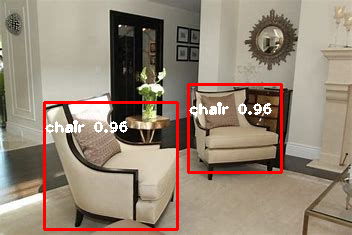

In [9]:
Starting_time =  time.time()
frame_id = 0

#Read an Image
Frame = cv2.imread("/content/Chair.jpg")
frame_id = frame_id + 1

Detection(Frame)


## 3D Bounding BOX 

### Load the Image

/content/Chair.jpg


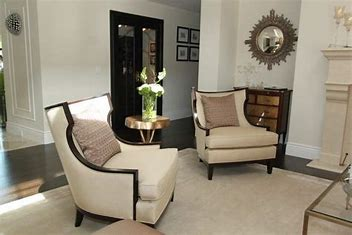

In [11]:
import glob
Chair_images = {name: cv2.imread(name) for name in glob.glob("/content/Chair.jpg")}

# Preview the images.
for name, image in Chair_images.items():
  print(name)   
  cv2_imshow(image)

### Create Bounding BOX 

Box landmarks of /content/Chair.jpg:


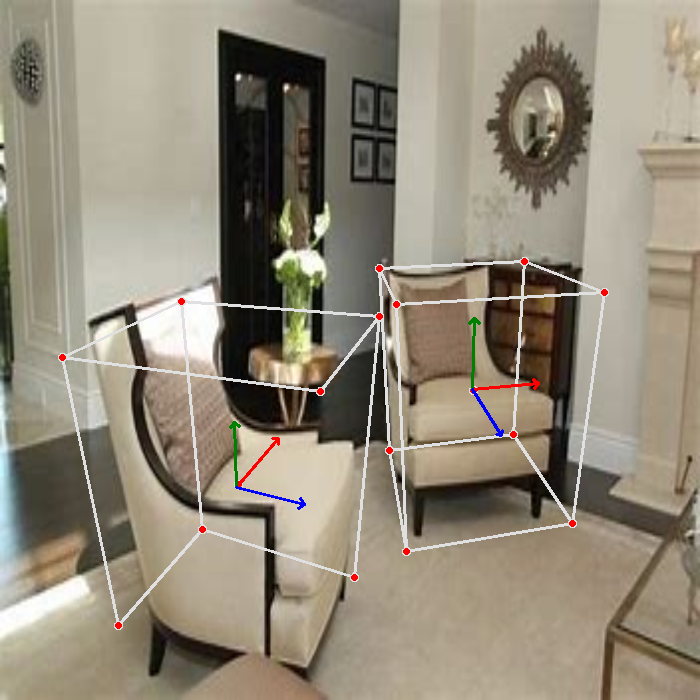

In [13]:
with mp_objectron.Objectron(
    static_image_mode=True,
    max_num_objects=5,
    min_detection_confidence=0.5,
    model_name='Chair') as objectron:
    #Change the model name according to the image.
    #[Camera, Chair, Cup, Shoe]
  # Run inference on shoe images.
  for name, image in Chair_images.items():
    # Convert the BGR image to RGB and process it with MediaPipe Objectron.
    image= cv2.resize(image,(700,700))
    results = objectron.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Draw box landmarks.
    if not results.detected_objects:
      print(f'No box landmarks detected on {name}')
      continue
    print(f'Box landmarks of {name}:')
    annotated_image = image.copy()
    for detected_object in results.detected_objects:
      mp_drawing.draw_landmarks(
          annotated_image, detected_object.landmarks_2d, mp_objectron.BOX_CONNECTIONS)
      mp_drawing.draw_axis(annotated_image, detected_object.rotation, detected_object.translation)
    cv2_imshow(annotated_image)